# 📊 TMDB 데이터 기반: '숨은 명작' 발굴 및 OTT 전략 분석

이 노트북은 TMDB 데이터를 분석하여 **인기 추천작**과 **숨은 명작**을 발굴하고, 이를 시각화하는 과정을 담고 있습니다.
**Plotly**를 사용하여 인터랙티브한 그래프를 제공합니다.

In [2]:
import plotly.io as pio

# GitHub에서 보이게 하려면 'png' 또는 'svg'로 설정해야 함
pio.renderers.default = "png"

## 1. 환경 설정 및 데이터 로드

In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import numpy as np

# 데이터 로드 (경로 확인 필요)
file_path = 'data/tmdb_cleaned.csv'

if os.path.exists(file_path):
    print(f"📂 '{file_path}' 데이터를 불러옵니다...")
    df = pd.read_csv(file_path)
else:
    print("❌ 데이터 파일을 찾을 수 없습니다. 경로를 확인해주세요.")

📂 'data/tmdb_cleaned.csv' 데이터를 불러옵니다...


## 2. 추천 알고리즘 및 그룹핑

In [4]:
# 통계 지표
C = df['vote_average'].mean()
# 인기작 기준: 상위 10%
m_popular = df['vote_count'].quantile(0.90) 
# 숨은 명작 기준: 상위 25% 미만 ~ 50표 이상
m_hidden_max = df['vote_count'].quantile(0.75)
m_hidden_min = 50

print(f"📊 [기준값] 인기작: {m_popular:.0f}표↑, 숨은명작: {m_hidden_min}~{m_hidden_max:.0f}표")

# 가중 평점 계산 함수
def weighted_rating(x, m=m_popular, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v + m) * R) + (m / (v + m) * C)

df['weighted_score'] = df.apply(weighted_rating, axis=1)

# 그룹 생성
# (1) 인기 추천작
popular_recs = df[(df['vote_count'] >= m_popular) & (df['vote_average'] >= C)].copy()
popular_recs['Group'] = '인기 추천작 (Popular)'

# (2) 숨은 명작
hidden_gems = df[(df['vote_count'] < m_hidden_max) & (df['vote_count'] >= m_hidden_min) & (df['vote_average'] >= 7.0)].copy()
hidden_gems['Group'] = '숨은 명작 (Hidden Gems)'

# 전체 데이터에 그룹 정보 매핑 (시각화용)
df['Group'] = '일반 작품'
df.loc[popular_recs.index, 'Group'] = '인기 추천작 (Popular)'
df.loc[hidden_gems.index, 'Group'] = '숨은 명작 (Hidden Gems)'

print("\n🎬 [인기 추천 Top 5]")
display(popular_recs[['title', 'vote_average', 'vote_count']].head(5))
print("\n💎 [숨은 명작 Top 5]")
display(hidden_gems[['title', 'vote_average', 'vote_count']].head(5))

📊 [기준값] 인기작: 3023표↑, 숨은명작: 50~452표

🎬 [인기 추천 Top 5]


,title,vote_average,vote_count
0,스타워즈 에피소드 4: 새로운 희망,8.200,21668
1,니모를 찾아서,7.817,20055
2,포레스트 검프,8.463,28871
3,제5원소,7.562,11295
5,킬 빌: 1부,7.970,18299



💎 [숨은 명작 Top 5]


,title,vote_average,vote_count
10,카라멜루,7.789,194
173,약속의 땅,7.282,78
174,The Incident,7.354,79
178,미라클 월드 런던: 시간의 끝에서,7.400,287
243,Speedy Gonzales,7.000,121


## 3. 시각화 분석 (EDA)

### (1) 장르별 시장 현황 (Genre Ranking)

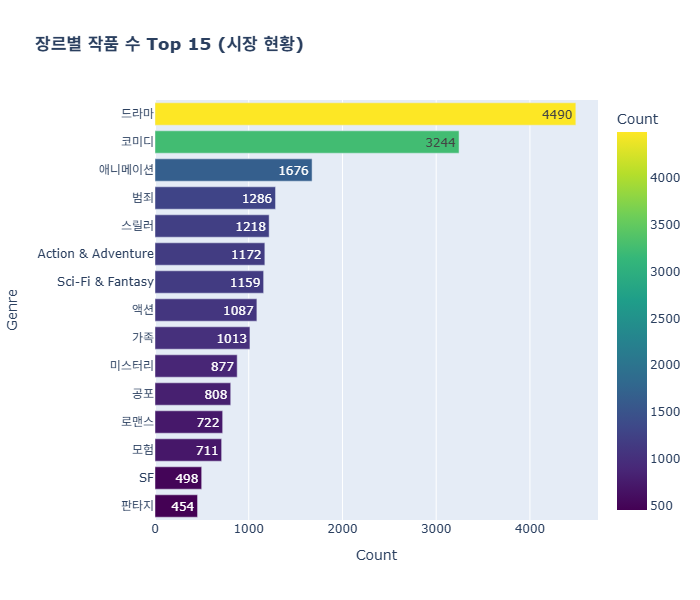

In [5]:
df['genres_split'] = df['genres'].str.split(',')
df_exploded = df.explode('genres_split')
df_exploded['genres_split'] = df_exploded['genres_split'].str.strip()
genre_counts = df_exploded['genres_split'].value_counts().head(15).reset_index()
genre_counts.columns = ['Genre', 'Count']

fig1 = px.bar(genre_counts, x='Count', y='Genre', orientation='h',
              text='Count', title='<b>장르별 작품 수 Top 15 (시장 현황)</b>',
              color='Count', color_continuous_scale='Viridis')
fig1.update_layout(yaxis={'categoryorder':'total ascending'}, height=600)
fig1.show()

### (2) 그룹별 특성 비교 (Box Plot)

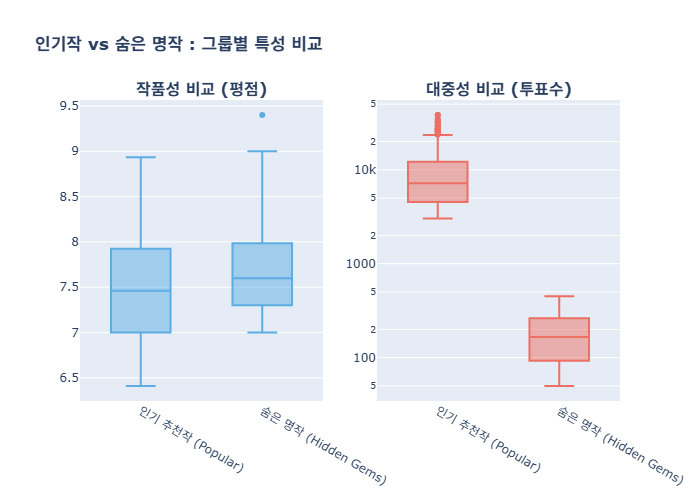

In [6]:
comp_df = pd.concat([popular_recs, hidden_gems])

fig2 = make_subplots(rows=1, cols=2, subplot_titles=("<b>작품성 비교 (평점)</b>", "<b>대중성 비교 (투표수)</b>"))

# 평점 Box
fig2.add_trace(go.Box(x=comp_df['Group'], y=comp_df['vote_average'], name='평점', 
                      marker_color='#5DADE2', boxpoints='outliers'), row=1, col=1)
# 투표수 Box
fig2.add_trace(go.Box(x=comp_df['Group'], y=comp_df['vote_count'], name='투표수', 
                      marker_color='#EC7063', boxpoints='outliers'), row=1, col=2)

fig2.update_yaxes(type="log", row=1, col=2) # 투표수는 로그 스케일
fig2.update_layout(title_text="<b>인기작 vs 숨은 명작 : 그룹별 특성 비교</b>", showlegend=False, height=500)
fig2.show()

### (3) 전략 포지셔닝 맵 (Scatter Plot)

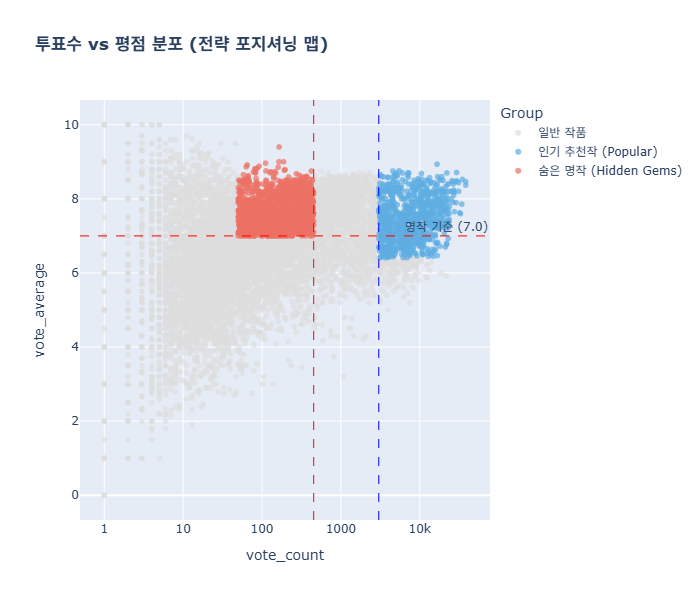

In [7]:
# 정렬 (숨은명작이 맨 위로 오게)
df_sorted = df.sort_values('Group', key=lambda x: x.map({'일반 작품':0, '인기 추천작 (Popular)':1, '숨은 명작 (Hidden Gems)':2}))

fig3 = px.scatter(df_sorted, x='vote_count', y='vote_average', 
                  color='Group', 
                  color_discrete_map={'일반 작품': '#DDDDDD', '인기 추천작 (Popular)': '#5DADE2', '숨은 명작 (Hidden Gems)': '#EC7063'},
                  hover_data=['title', 'genres'], 
                  title='<b>투표수 vs 평점 분포 (전략 포지셔닝 맵)</b>',
                  log_x=True)

fig3.add_vline(x=m_popular, line_width=1, line_dash="dash", line_color="blue", annotation_text="인기작 기준")
fig3.add_vline(x=m_hidden_max, line_width=1, line_dash="dash", line_color="red", annotation_text="숨은 명작 상한선")
fig3.add_hline(y=7.0, line_width=1, line_dash="dash", line_color="red", annotation_text="명작 기준 (7.0)")

fig3.update_traces(marker=dict(size=6, opacity=0.7))
fig3.update_layout(height=600)
fig3.show()

### (4) OTT 플랫폼별 장르 특화도 (Heatmap)

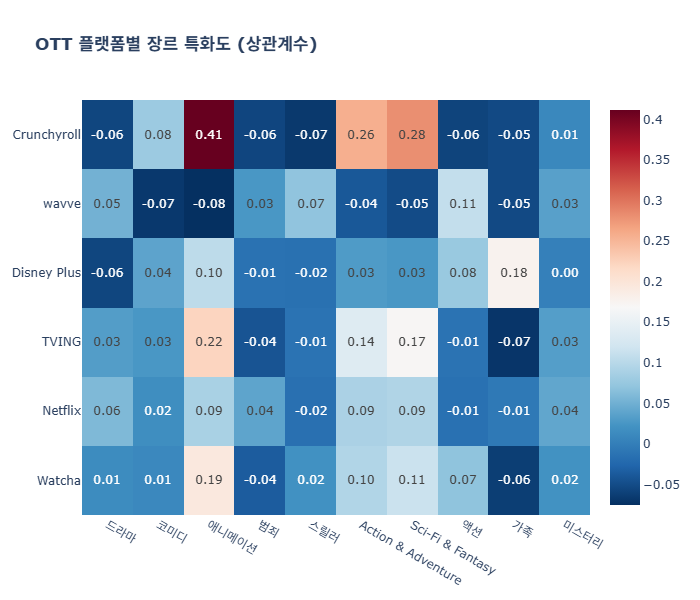

In [8]:
top_providers = df['providers'].str.split(',').explode().str.strip().value_counts().head(7).index.tolist()
if '기타' in top_providers: top_providers.remove('기타')
top_genres = df['genres'].str.split(',').explode().str.strip().value_counts().head(10).index.tolist()
if '기타' in top_genres: top_genres.remove('기타')

corr_df = pd.DataFrame()
for provider in top_providers:
    corr_df[provider] = df['providers'].apply(lambda x: 1 if provider in [p.strip() for p in x.split(',')] else 0)
for genre in top_genres:
    corr_df[genre] = df['genres'].apply(lambda x: 1 if genre in [g.strip() for g in x.split(',')] else 0)

target_corr = corr_df.corr().loc[top_providers, top_genres]

fig4 = px.imshow(target_corr, text_auto=".2f", aspect="auto",
                 color_continuous_scale='RdBu_r', origin='lower',
                 title='<b>OTT 플랫폼별 장르 특화도 (상관계수)</b>')
fig4.update_layout(height=600)
fig4.show()

### (5) OTT 보유 비율 비교 (Grouped Bar)

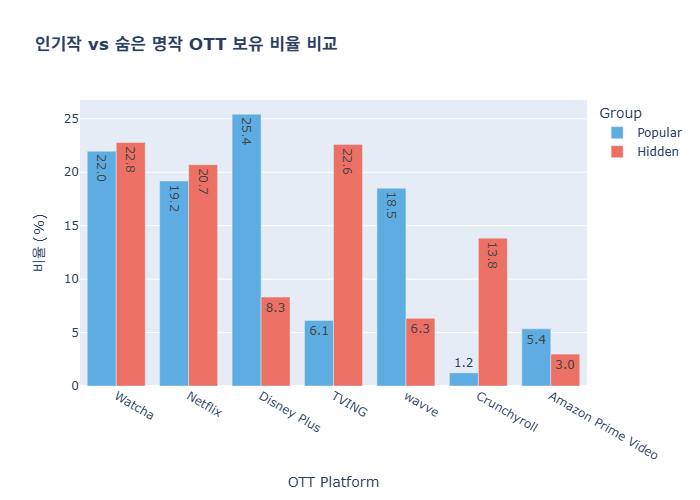

In [9]:
def get_distribution(target_df):
    split_data = target_df['providers'].str.split(',').explode().str.strip()
    split_data = split_data[split_data != '기타']
    return split_data.value_counts(normalize=True) * 100

pop_ott = get_distribution(popular_recs)
hidden_ott = get_distribution(hidden_gems)
top_otts = pop_ott.add(hidden_ott, fill_value=0).sort_values(ascending=False).head(7).index

ott_comp = pd.DataFrame({'Popular': pop_ott, 'Hidden': hidden_ott}).loc[top_otts].fillna(0)
ott_comp.index.name = 'OTT_Platform'
ott_comp = ott_comp.reset_index().melt(id_vars='OTT_Platform', var_name='Group', value_name='Percentage')

fig5 = px.bar(ott_comp, x='OTT_Platform', y='Percentage', color='Group', barmode='group',
              text_auto='.1f',
              title='<b>인기작 vs 숨은 명작 OTT 보유 비율 비교</b>',
              color_discrete_map={'Popular': '#5DADE2', 'Hidden': '#EC7063'})
fig5.update_layout(xaxis_title="OTT Platform", yaxis_title="비율 (%)", height=500)
fig5.show()

### (6) 콘텐츠 유형 비교 (Movie vs TV)

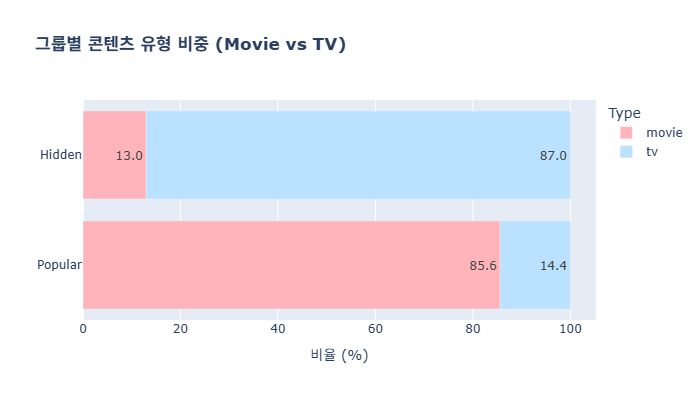

In [10]:
def get_type_ratio(target_df):
    return target_df['type'].value_counts(normalize=True) * 100

pop_type = get_type_ratio(popular_recs)
hidden_type = get_type_ratio(hidden_gems)
type_df = pd.DataFrame({'Popular': pop_type, 'Hidden': hidden_type}).T
type_df.index.name = 'Recommendation_Group'
type_melt = type_df.reset_index().melt(id_vars='Recommendation_Group', var_name='Type', value_name='Percentage')

fig6 = px.bar(type_melt, y='Recommendation_Group', x='Percentage', color='Type', orientation='h',
              text_auto='.1f',
              title='<b>그룹별 콘텐츠 유형 비중 (Movie vs TV)</b>',
              color_discrete_sequence=['#FFB3BA', '#BAE1FF'])
fig6.update_layout(xaxis_title="비율 (%)", yaxis_title="", height=400)
fig6.show()